In [1]:
import numpy as np
import os
import cv2
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import keras
import tensorflow as tf
import keras.backend as K
from collections import Counter
from tensorflow.python.client import device_lib
from keras.optimizers import Adam, Adamax, SGD
import imutils
import tensorflow_addons as tfa
from keras.models import load_model

2022-12-29 15:55:13.189322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 15:55:13.342525: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-29 15:55:13.377276: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-29 15:55:13.901866: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:

os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
gpu = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)
tf.keras.backend.clear_session()
TF_ENABLE_ONEDNN_OPTS=0
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(tf.device('/gpu:0'))

tf.device('/gpu:0')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-12-29 15:55:19.419126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-12-29 15:55:21.183474: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2022-12-29 15:55:21.183615: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7325 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:19:00.0, compute capability: 8.6


In [3]:
_,sample_rate=librosa.load("/home/neel/Acoustic/Acoustics/dataset/datachunks/channel1_normal_train107_23.wav",sr=None)
duration_GT= len(_)/sample_rate
label_file_path="/home/neel/Acoustic/Acoustics/dataset/labels/"
labels=[]
for i in os.listdir(label_file_path):
    labels.append(i[:-4])
dataset=[]
for label in labels:
    row=[]
    file=open(label_file_path+label+".txt","r")
    label_s=file.read()
    label_list=label_s.replace('\n','').split(" ")
    channel1="channel1_"+label+".wav"
    channel2="channel2_"+label+".wav"
    audio,sample_rate=librosa.load("dataset/datachunks/"+channel1,sr=None)
    duration = len(audio)/sample_rate
    if duration == duration_GT:
        row.append(channel1)
        row.append(channel2)
        for cord in label_list[1:]:
            row.append(cord)
        X=float(row[2])
        Y=float(row[3])
        W=float(row[4])
        H=float(row[5])
        row[2]=X-(W/2)
        row[3]=Y-(H/2)
        row[4]=X+(W/2)
        row[5]=Y+(H/2)
        dataset.append(row)

In [4]:
datasets=pd.DataFrame(dataset)

In [ ]:
datasets.to_csv('dataset/train.csv', header=False, index=False)
del dataset, datasets, labels

In [5]:
base_path="/home/neel/Acoustic/Acoustics/dataset"
audio_path=os.path.sep.join([base_path,"datachunks"])
annots_path=os.path.sep.join([base_path,"train.csv"])

base_output="/home/neel/Acoustic/Acoustics/output2.0"
model_path=os.path.sep.join([base_output,"detector.h5"])
plot_path=os.path.sep.join([base_output,"plot.png"])
test_file=os.path.sep.join([base_output,"test.txt"])

In [7]:
print("[INFO] loading dataset...")
rows = open(annots_path).read().strip().split("\n")
spectrogram=np.empty(((len(rows)),525,553,2), dtype="float32")
bounding_box_cords=[]
window_size=int(1048)
wd = signal.windows.hamming(window_size)
slide_size = int(1)
overlap = window_size - slide_size
filenames=[]
cnt=0
for row in rows:
    # print(cnt)
    row = row.split(",")
    (filename1,filename2,X, Y, W, H) = row
    channel1_Path = os.path.sep.join([audio_path, filename1])
    channel2_path = os.path.sep.join([audio_path, filename2])
    
    channel1,sample_rate=librosa.load(channel1_Path,sr=None)
    channel2,sample_rate=librosa.load(channel2_path,sr=None)

    # image1 = cv2.imread(imagePath1)
    # image2=cv2.imread(imagePath2)
    # (h, w) = image1.shape[:2]

    # startX = float(startX) / w
    # startY = float(startY) / h
    # endX = float(endX) / w
    # endY = float(endY) / h

    frequency,time,spectrum1=signal.spectrogram(channel1,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')
    frequency,time,spectrum2=signal.spectrogram(channel2,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')

    # print(image1.shape)
    data=np.stack((spectrum1,spectrum2),axis=-1)
    spectrogram[cnt]=data
    del data,frequency,time
    cnt+=1
    bounding_box_cords.append((X, Y, W, H))
    filenames.append([filename1,filename2])
    # filenames.append(filename1)
print("Done.")

[INFO] loading dataset...
Done.


In [9]:
targets = np.array(bounding_box_cords, dtype="float32")

del bounding_box_cords,rows

In [10]:
print(targets.shape)
print(spectrogram.shape)

(8831, 4)
(8831, 525, 553, 2)


In [11]:
split = train_test_split(spectrogram, targets, filenames, test_size=0.10,random_state=42)
del spectrogram, targets,filenames
(trainData, testData) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]
del split

print("[INFO] saving testing filenames...")
f = open(test_file, "w")
for i in testFilenames:
    f.write(i[0]+","+i[1])
    f.write("\n")
# f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


In [15]:
from keras.layers import LeakyReLU
model= tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32,(3,3), padding='valid',strides=2, input_shape=(525,553,2), activation='relu'))
# model.add(LeakyReLU(alpha=0.03))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'))
# model.add(tf.keras.layers.Conv2D(32,(3,3), padding='valid',strides=2,activation='relu'))
# # model.add(LeakyReLU(alpha=0.03))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'))
# model.add(tf.keras.layers.Conv2D(64,(3,3), padding='valid', strides=2,activation='relu'))
# # model.add(LeakyReLU(alpha=0.03))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'))
# model.add(tf.keras.layers.Conv2D(64,(3,3), padding='valid',strides=2,activation='relu'))
# # model.add(LeakyReLU(alpha=0.03))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(LeakyReLU(alpha=0.03))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64,activation='relu'))
# model.add(LeakyReLU(alpha=0.03))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32,activation='relu'))
# model.add(LeakyReLU(alpha=0.03))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4,activation='relu'))
# model.add(LeakyReLU(alpha=0.03))

In [16]:
init_lr=1e-4

epoch=10
batch_size=32
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_lr,
    decay_steps=20,
    decay_rate=0.1,
    staircase=True)

opt = SGD(learning_rate=lr_schedule ,momentum=0.9, )
model.compile(
  optimizer='adam',
  loss='mse',
  metrics=['accuracy'],run_eagerly=True)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 262, 276, 32)      608       
                                                                 
 batch_normalization (BatchN  (None, 262, 276, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 131, 138, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 578496)            0         
                                                                 
 dense (Dense)               (None, 128)               74047616  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0

In [17]:
with tf.device("/gpu:0"):
	H = model.fit(
		trainData, trainTargets,
		validation_data=(testData, testTargets),
		batch_size=batch_size,
		epochs=epoch,
		verbose=1)
	print(H)

2022-12-29 15:59:58.082423: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 18457702200 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 569966592/51049857024
2022-12-29 15:59:58.082451: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                      7681802240
InUse:                      1194247072
MaxInUse:                   1786581024
NumAllocs:                         502
MaxAllocSize:                296189952
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-12-29 15:59:58.082468: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-12-29 15:59:58.082488: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_alloca

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [21]:
print("[INFO] saving object detector model...")
model.save(model_path, save_format="h5")
N = epoch
# plt.style.use("ggplot")
# plt.figure()
# plt.plot(np.arange(0, N), H.history["accuracy"], label="train_loss")
# plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_loss")
# plt.title("Bounding Box Regression MSE on Training Set")
# plt.xlabel("Epoch #")
# plt.ylabel("Accuracy")
# plt.legend(loc="lower left")
# plt.savefig(plot_path)

[INFO] saving object detector model...


In [ ]:
del spectrum1, spectrum2, trainData, testData, model, trainTargets

In [14]:
model=load_model('/home/neel/Acoustic/Acoustics/output2.0/detector.h5')
for i,img in enumerate(testFilenames):
    imagePath1=os.path.sep.join([audio_path, img[0]])
    imagePath2=os.path.sep.join([audio_path, img[1]])
    channel1,sample_rate=librosa.load(imagePath1,sr=None)
    channel2,sample_rate=librosa.load(imagePath2,sr=None)
    
    frequency,time,spectrum1=signal.spectrogram(channel1,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')
    frequency,time,spectrum2=signal.spectrogram(channel2,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')
    spectrum1=np.expand_dims(spectrum1,axis=0)
    spectrum2=np.expand_dims(spectrum2,axis=0)
    image=np.stack((spectrum1,spectrum2),axis=-1)

    preds = model.predict(image)[0]
    (startX, startY, endX, endY) = preds
    print(imagePath1)
    # image2 = cv2.imread(os.path.sep.join(["/home/neel/Acoustic/yolov5_training/img_data/frames", img[0][9:]]))
    # image2 = imutils.resize(image2, width=600)
    # (h, w) = image1.shape[:2]
    # startX = startX*w
    # startY = startY*h
    # endX = endX*w
    # endY = endY*h
    f=open("/home/neel/Acoustic/Acoustics/dataset/labels/"+img[0][9:-4]+".txt")
    ground_truth=f.read()
    print("Ground truth: ",ground_truth[1:])
    print("Predicted: ",startX, startY, endX, endY)
    # cv2.rectangle(image2, (startX, startY), (endX, endY),(0, 255, 0), 2)
	# # show the output image
    # cv2.imwrite("/home/neel/Acoustic/Acoustics/output/test_img/"+img[0], image2)
    # cv2.imshow("Output", image2)
    # cv2.waitKey(0)
    if i==2:
        break
    

1/1 [==============================] - 0s 99ms/step
/home/neel/Acoustic/Acoustics/dataset/datachunks/channel1_4m_train51_3.wav
Ground truth:   0.556597 0.60463 0.0798611 0.0666667

Predicted:  0.0 9.353084e-05 0.0 1.4486088e-05
1/1 [==============================] - 0s 20ms/step
/home/neel/Acoustic/Acoustics/dataset/datachunks/channel1_normal_train119_26.wav
Ground truth:   0.711458 0.462037 0.0576389 0.0462963

Predicted:  0.0 6.1393635e-05 5.4580255e-07 2.8672457e-05
1/1 [==============================] - 0s 19ms/step
/home/neel/Acoustic/Acoustics/dataset/datachunks/channel1_5m_train29_23.wav
Ground truth:   0.100694 0.580093 0.0652778 0.0509259

Predicted:  0.0 5.716248e-05 4.8393536e-05 2.7515198e-05


2022-12-29 15:59:07.416994: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


1/1 [==============================] - 3s 3s/step
0.0 0.16537079005502164 0.05323603400029242 -0.09584552783053368


2022-12-29 15:59:08.725378: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


FileNotFoundError: [Errno 2] No such file or directory: '/home/neel/Acoustic/yolov5_training/img_data/frames/3m_train2_5.jpg'

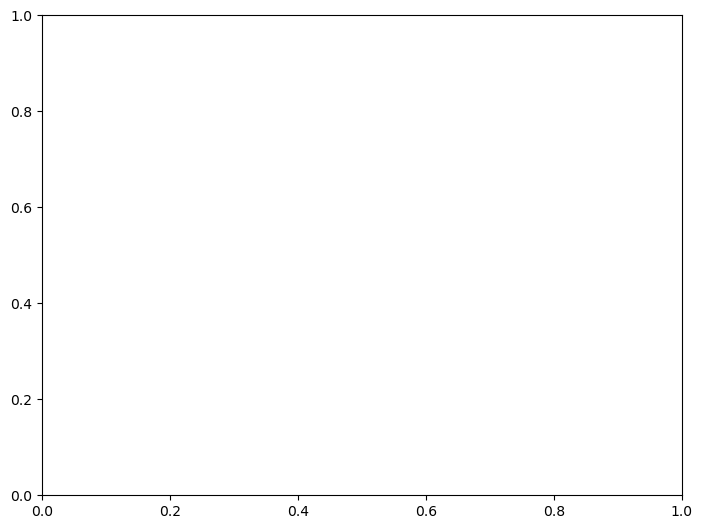

In [12]:

from matplotlib import patches
import matplotlib.pyplot as plt
import cv2
fig = plt.figure()
channel1,sample_rate=librosa.load("/home/neel/Acoustic/Acoustics/dataset/datachunks/channel1_3m_train2_5.wav",sr=None)
channel2,sample_rate=librosa.load("/home/neel/Acoustic/Acoustics/dataset/datachunks/channel2_3m_train2_5.wav",sr=None)
frequency,time,spectrum1=signal.spectrogram(channel1,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')
frequency,time,spectrum2=signal.spectrogram(channel2,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')
spectrum1=np.expand_dims(spectrum1,axis=0)
spectrum2=np.expand_dims(spectrum2,axis=0)
image=np.stack((spectrum1,spectrum2),axis=-1)
preds = model.predict(image)[0]
(startX, startY, endX, endY) = preds
startX,startY,endX, endY=startX*1440,startY*1080, endX*1440, endY*1080
width=endX-startX
height=endY-startY
ax = fig.add_axes([0,0,1,1])
print(startX,startY,width,height)
image = plt.imread('/home/neel/Acoustic/yolov5_training/img_data/frames/3m_train2_5.jpg')
plt.imshow(image)
rect = patches.Rectangle((startX,startY), width, height, edgecolor='r', facecolor='none')
ax.add_patch(rect)
